In [1]:
import time
import sys
import tracemalloc
import random

random.seed(42)

# Алгоритм Дейкстры

## Формат данных

### Входные данные
- **`graph`:** Словарь, представляющий граф. Ключи словаря - это вершины, значения - другие словари, где каждый ключ - это соседняя вершина, а значение - вес ребра до этой вершины.
- **`start_vertex`:** начальная вершина, с которой начинается поиск кратчайшего пути.

### Выходные данные

- **`distances`:** Словарь, где ключ - вершина, значение - расстояние от start_vertex до этой вершины. Если вершина недостижима, значение может быть обозначено как `float('inf')`, в зависимости от реализации алгоритма.

In [12]:
def correctness_test(dijkstra_alg):
    small_graph = {
        0: {1: 4, 2: 1},
        1: {0: 4, 3: 1, 2: 2},
        2: {0: 1, 1: 2, 3: 5},
        3: {1: 1, 2: 5, 4: 3},
        4: {3: 3},
        5: {}
    }
    start_vertex = 0
    small_graph_result = dijkstra_alg(small_graph, start_vertex)
    
    expected_distances = {0: 0, 1: 3, 2: 1, 3: 4, 4: 7, 5: float('inf')}
    
    assert small_graph_result == expected_distances, f"Expected {expected_distances}, got {small_graph_result}"
    print("Тест на малом наборе данных пройден успешно.")
    
def performance_test(dijkstra_alg):
    for num_vertices in [1000, 5000, 10000, 25000, 50000, 100000]:
        large_graph = {i: {} for i in range(num_vertices)}
        for _ in range(num_vertices * 100):
            a, b = random.randint(0, num_vertices-1), random.randint(0, num_vertices-1)
            weight = random.randint(1, 10)
            large_graph[a][b] = weight
        
        start_vertex = 0

        tracemalloc.start()
        start_time = time.time()

        results = dijkstra_alg(large_graph, start_vertex)

        elapsed_time = time.time() - start_time
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        print(f"Тест для {num_vertices} вершин")
        print(f"Время выполнения: {elapsed_time:.4f} сек")
        print(f"Использовано памяти: {current / 10**6:.4f} MB, Пиковое использование: {peak / 10**6:.4f} MB")
        print("------")


## Базовая реализация

In [13]:
def dijkstra_basic(graph, start_vertex):
    # Инициализируем расстояния бесконечностью и обнуляем расстояние от стартовой вершины
    d = {v: float('inf') for v in graph}
    d[start_vertex] = 0

    # Используем множество для отслеживания необработанных вершин
    unvisited = set(graph)

    while unvisited:
        # Выбираем необработанную вершину с минимальным расстоянием
        current_vertex = min(unvisited, key=lambda vertex: d[vertex])

        # Если минимальное расстояние бесконечно, оставшиеся вершины недостижимы
        if d[current_vertex] == float('inf'):
            break

        unvisited.remove(current_vertex)

        # Рассматриваем каждое соседнее ребро исходящее из текущей вершины
        for neighbor, weight in graph[current_vertex].items():
            if neighbor in unvisited:
                # Релаксация ребра
                new_distance = d[current_vertex] + weight
                if new_distance < d[neighbor]:
                    d[neighbor] = new_distance

    return d


In [14]:
correctness_test(dijkstra_basic)
performance_test(dijkstra_basic)

Тест на малом наборе данных пройден успешно.
Тест для 1000 вершин
Время выполнения: 0.0511 сек
Использовано памяти: 0.0390 MB, Пиковое использование: 0.0918 MB
------
Тест для 5000 вершин
Время выполнения: 1.2088 сек
Использовано памяти: 0.1497 MB, Пиковое использование: 0.5277 MB
------
Тест для 10000 вершин
Время выполнения: 4.1882 сек
Использовано памяти: 0.2973 MB, Пиковое использование: 1.0573 MB
------
Тест для 25000 вершин
Время выполнения: 23.9201 сек
Использовано памяти: 1.3138 MB, Пиковое использование: 2.9574 MB
------
Тест для 50000 вершин
Время выполнения: 99.3462 сек
Использовано памяти: 2.6248 MB, Пиковое использование: 5.9167 MB
------
Тест для 100000 вершин
Время выполнения: 395.5662 сек
Использовано памяти: 5.2462 MB, Пиковое использование: 11.8353 MB
------


### Временная сложность

`V` раз осуществляем поиск вершины с минимальной величиной `d` среди `O(V)` непомеченных вершин и `E` раз проводим релаксацию за `O(1)`. Итак, общее время `O(V^2 + E)`

### Сложность по памяти
- **Хранение расстояний:** Для каждой вершины графа хранится текущее минимальное расстояние от начальной вершины, что требует `O(V)` памяти.
- **Множество необработанных вершин:** Для отслеживания необработанных вершин используется множество, которое также требует `O(V)` памяти
- **Хранение графа:** Входные данные графа (вершины и рёбра) требуют `O(V+E)` памяти.

Общая сложность по памяти `O(V+E)`

## Двоичная куча

In [16]:
import heapq

def dijkstra_heap(graph, start_vertex):
    d = {v: float('inf') for v in graph}
    d[start_vertex] = 0
    
    # Инициализируем кучу с начальной вершиной
    heap = [(0, start_vertex)]
    
    while heap:
        current_distance, current_vertex = heapq.heappop(heap)
        
        if current_distance > d[current_vertex]:
            continue
        
        for neighbor, weight in graph[current_vertex].items():
            distance = current_distance + weight
            if distance < d[neighbor]:
                d[neighbor] = distance
                heapq.heappush(heap, (distance, neighbor))
    
    return d


In [17]:
correctness_test(dijkstra_heap)
performance_test(dijkstra_heap)

Тест на малом наборе данных пройден успешно.
Тест для 1000 вершин
Время выполнения: 0.0171 сек
Использовано памяти: 0.0557 MB, Пиковое использование: 0.0763 MB
------
Тест для 5000 вершин
Время выполнения: 0.1364 сек
Использовано памяти: 0.2506 MB, Пиковое использование: 0.7653 MB
------
Тест для 10000 вершин
Время выполнения: 0.3159 сек
Использовано памяти: 0.4030 MB, Пиковое использование: 1.6048 MB
------
Тест для 25000 вершин
Время выполнения: 1.0350 сек
Использовано памяти: 1.4225 MB, Пиковое использование: 4.6748 MB
------
Тест для 50000 вершин
Время выполнения: 2.0798 сек
Использовано памяти: 2.7348 MB, Пиковое использование: 9.7088 MB
------
Тест для 100000 вершин
Время выполнения: 5.5225 сек
Использовано памяти: 5.3568 MB, Пиковое использование: 19.1792 MB
------


### Временная сложность

Используя двоичную кучу можно выполнять операции извлечения минимума и обновления элемента за `O(logV)`. Тогда время работы алгоритма Дейкстры составит `O(VlogV+ElogV)=O(ElogV)`
### Сложность по памяти
- **Хранение расстояний:** Для каждой вершины графа хранится текущее минимальное расстояние от начальной вершины, что требует `O(V)` памяти.
- **Множество необработанных вершин:** Для отслеживания необработанных вершин используется множество, которое также требует `O(V)` памяти
- **Хранение графа:** Входные данные графа (вершины и рёбра) требуют `O(V+E)` памяти.

Общая сложность по памяти `O(V+E)`

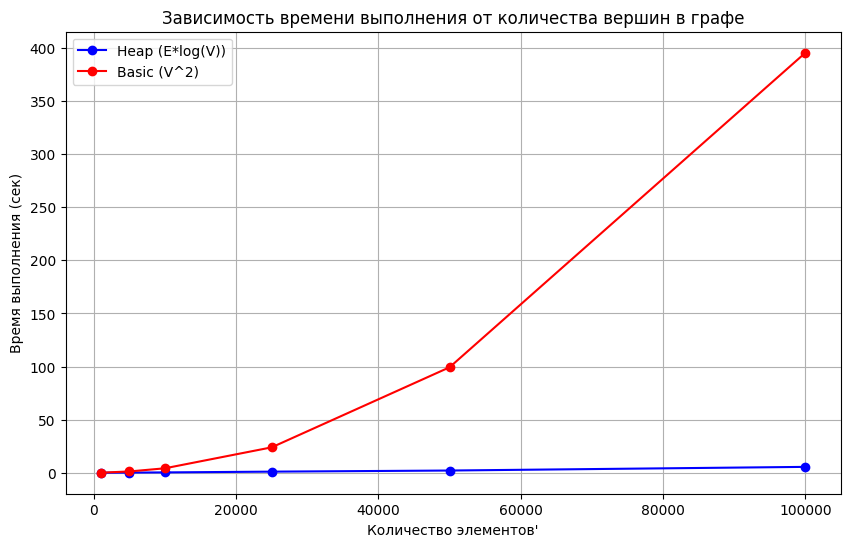

In [22]:
import matplotlib.pyplot as plt
import numpy as np

vertices = np.array([1000, 5000, 10000, 25000, 50000, 100000])
times_heap = np.array([0.0171, 0.1364, 0.3159, 1.0350, 2.0798, 5.5225])

times_basic = np.array([0.0511, 1.2088, 4.1882, 23.9201, 99.3462, 395.5662])

# Построение графиков на одном plot
plt.figure(figsize=(10, 6))
plt.plot(
    vertices,
    times_heap,
    marker="o",
    linestyle="-",
    color="b",
    label="Heap (E*log(V))",
)
plt.plot(
    vertices,
    times_basic,
    marker="o",
    linestyle="-",
    color="r",
    label="Basic (V^2)",
)

plt.title("Зависимость времени выполнения от количества вершин в графе")
plt.xlabel("Количество элементов'")
plt.ylabel("Время выполнения (сек)")
plt.legend()
plt.grid(True)
plt.show()